# How to run parametric studies with `sigmaepsilon.solid.fourier`, `Jupyter Notebooks` and `Papermill`

In this notebook, you will see an example on
- How to define a specific plate bending problem using the `sigmaepsilon.solid.fourier` package.
- How to run a parametric Jupyter Notebook from Python code and save calculation results to parquet files.
- How to read data from parquet files and use PyVista to plot results.

## The plate bending problem.

For the definition of the plate bending problem, see the `Theory Guide` section of the documentation of the `sigmaepsilon.solid.fourier` Python package.

You can see an example Notebook that defines and solves a plate bending problem at `"..\examples\plate_concentrated_load.ipynb"`. After solving the problem, it also saves the results to parquet files. The name of the results files can be controlled through the input parameters.

## Running the parametric Notebook with `Papermill`

In [10]:
import os
import papermill as pm

notebook_id = "_00001"

# Path to your original notebook
input_notebook = "..\examples\plate_concentrated_load.ipynb"

# Path where the executed notebook (with outputs) will be saved
output_notebook = notebook_id + "plate_concentrated_load_output.ipynb"

# Path to the directory where the executed notebook will be saved
notebook_dir = os.getcwd()
file_name = os.path.join(notebook_dir, notebook_id)

# Dictionary of parameters you want to override
params = {
    "load_position": (350.0, 450.0),
    "load_value": (-50.0, 0.0, 0.0),
    "file_name" : file_name
}

pm.execute_notebook(
    input_notebook,
    output_notebook,
    parameters=params
)

print("Notebook execution complete. Output saved to:", output_notebook)

Executing:   0%|          | 0/13 [00:00<?, ?cell/s]

Notebook execution complete. Output saved to: _00001plate_concentrated_load_output.ipynb


## Read the results

In [11]:
from sigmaepsilon.mesh import PointData

parquet_file_name = file_name + "_res2d" + ".parquet"
pd = PointData.from_parquet(parquet_file_name)

In [12]:
points_of_evaluation = pd.x
points_of_evaluation.shape

(30000, 2)

In [13]:
strains = pd.db["results"].to_numpy()[:,3:8]
strains.shape

(30000, 5)

## Plot with `PyVista`

In [14]:
import pyvista as pv

util_parquet_file_name = file_name + "_res3d" + ".parquet"
pd = PointData.from_parquet(util_parquet_file_name)

point_cloud = pv.PolyData(pd.x)
point_cloud["scalars"] = pd["util"].to_numpy()

point_cloud

PolyData (0x19f0cff4160)
  N Cells:    600000
  N Points:   600000
  N Strips:   0
  X Bounds:   0.000e+00, 6.000e+02
  Y Bounds:   0.000e+00, 8.000e+02
  Z Bounds:   -1.250e+01, 1.250e+01
  N Arrays:   1

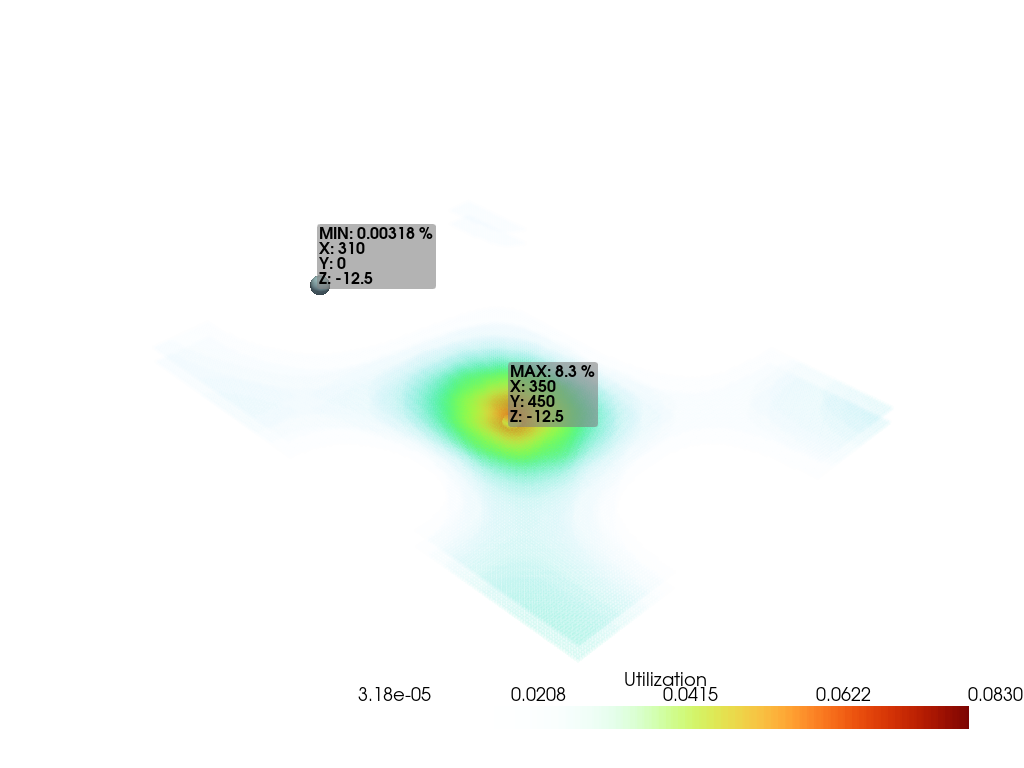

In [15]:
from sigmaepsilon.core.formatting import floatformatter
import numpy as np

formatter = floatformatter(sig=3)  # to format strings to 3 significant digits

plotter = pv.Plotter(notebook=True)

scalars = pd["util"].to_numpy()
points = pd.x
max_index = np.argmax(scalars)
min_index = np.argmin(scalars)

p_min = point_cloud.points[min_index]
p_max = point_cloud.points[max_index]
label_coords = np.array([p_min, p_max])

labels = [
    (
        f"MIN: {formatter.format(scalars.min()*100)} %"
        f"\nX: {formatter.format(points[min_index, 0])}"
        f"\nY: {formatter.format(points[min_index, 1])}"
        f"\nZ: {formatter.format(points[min_index, 2])}"
    ),
    (
        f"MAX: {formatter.format(scalars.max()*100)} %"
        f"\nX: {formatter.format(points[max_index, 0])}"
        f"\nY: {formatter.format(points[max_index, 1])}"
        f"\nZ: {formatter.format(points[max_index, 2])}"
    ),
]

plotter.add_mesh(
    point_cloud,
    scalars="scalars",
    cmap="turbo",
    lighting=False,
    scalar_bar_args={"title": "Utilization"},
    render_points_as_spheres=True,
    opacity="sigmoid",
)

plotter.add_point_labels(
    label_coords,
    labels,
    point_size=20,
    font_size=16,
    always_visible=True,
    shape_color="grey",
    shape_opacity=0.6,
    render_points_as_spheres=True,
)

#plotter.show(jupyter_backend="trame")
plotter.show(jupyter_backend="static")